# Augmentation de données sur cas pratique (histologie)

**Pour demander à Colab de nous mettre à disposition du GPU, il faut aller dans `Modifier > Paramètres du notebook > Accélérateur matériel` et sélectionner 'GPU'.
Cela va avoir pour effet de redémarrer l'environnement.**

D'abord, nous avons besoin d'installer une version `nightly` de `tensorflow-datasets` pour accéder aux nouvelles fonctionnalités de type `benchmark` (statistiques d'exécution).

In [ ]:
!pip uninstall tensorflow-datasets
!pip install tfds-nightly
!pip install -U tensorboard-plugin-profile

Puis nous importons les packages d'intérêt.

In [1]:
from typing import List, Tuple

import os
import numpy as np

import tensorflow as tf
print(f'Tensorflow version {tf.__version__}')
import tensorflow_datasets as tfds

Tensorflow version 2.4.1


Enfin nous demandons à Colab de charger le contenu de notre drive (en réalité, c'est un _point de montage_).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

On s'intéresse au data set suivant : `colorectal_histology`, issu de l'article suivant : 

**Kather, J., Weis, CA., Bianconi, F. et al. Multi-class texture analysis in colorectal cancer histology. Sci Rep 6, 27988 (2016). https://doi.org/10.1038/srep27988**

Ce data set consiste en la classification en 8 classes d'images histologiques de taille 150x150x3 de tissus prélevés dans le cadre de l'étude du cancer colorectal.
L'image ci-dessous est tirée de l'article de Kather et al., et reprend, pour chaque ligne, l'un des 8 types de tissus à classifier.

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsrep27988/MediaObjects/41598_2016_Article_BFsrep27988_Fig1_HTML.jpg?as=webp" width="800">
Légende [Figure 1]: 

_**Representative images from our dataset.** Here, the first 10 images of every tissue class in our dataset are shown. They represent the wide variation of illumination, stain intensity and tissue textures present in routine histopathological images. Images were extracted from 10 independent samples of colorectal cancer (CRC) primary tumours. **(a) tumour epithelium, (b) simple stroma, (c) complex stroma (stroma that contains single tumour cells and/or single immune cells), (d) immune cell conglomerates, (e) debris and mucus, (f) mucosal glands, (g) adipose tissue, (h) background.**_

### Chargement des données avec `tensorflow_datasets`.

In [2]:
# arguments communs.
args = {
    'shuffle_files': True, # on permute aléatoirement les images.
    'batch_size': 256, # taille de batch : 256.
    'as_supervised': True,
    'data_dir': '/content/gdrive/MyDrive/data/',
    'with_info': True
}
# 3 jeux de données : train, validation et test.
ds_train, info = tfds.load(
    'colorectal_histology',
    split='train[:80%]', 
    **args
)
ds_val, info = tfds.load(
    'colorectal_histology',
    split='train[80%:90%]',
    **args
)
ds_test, info = tfds.load(
    'colorectal_histology',
    split='train[90%:]',
    **args
)
# on affiche les informations associées au data set.
print(info)

tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_path='datasets/colorectal_histology/2.0.0',
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susanne M and Schad

### Type de données

In [ ]:
print(info.features)

### Affichage des images

On reprend la librairie `matplotlib` pour nos images.

In [ ]:
import matplotlib.pyplot as plt

In [60]:
# ici on sélectionne le premier batch d'images avec les labels correspondants.
def store_data(ds: tf.data.Dataset) -> Tuple[List[np.ndarray], List[int]]:
    images, labels = [], []
    for batch_img, batch_label in tfds.as_numpy(ds):
        for image, label in zip(batch_img, batch_label):
            images.append(image)
            labels.append(label)
    return images, labels
images, labels = store_data(ds_train)
print(f"Nombre d'images stockées d'entraînement : {len(images)}")

Nombre d'images stockées d'entraînement : 4000


Labels: [0 1 2 3 4 5 6 7] et nombres: [513 498 488 499 499 497 507 499]
(fréquences [0.128 0.124 0.122 0.125 0.125 0.124 0.127 0.125])


<ipython-input-61-561d4b76e724>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


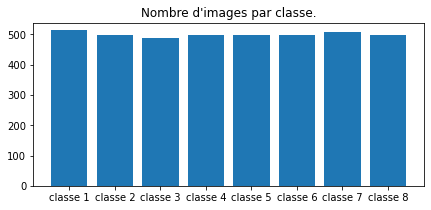

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
labs, counts = np.unique(labels, return_counts=True)
print(f'Labels: {labs} et nombres: {counts}\n(fréquences {(counts/counts.sum()).round(3)})')
arr = ax.bar(labs, counts, align='center')
ax.set_xticks(range(8))
ax.set_xticklabels([f'classe {i}' for i in range(1, 9)])
ax.set_title("Nombre d'images par classe.")
fig.show()

On retrouve le même type précédent : `uint8`.

In [ ]:
image_0 = images[0]
image_0[0, 0, :]

Et on affiche 25 images avec les classes correspondantes.

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    ax = axes[i//5, i%5]
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f'Classe {labels[i]}')
fig.show()

On peut en afficher un plus grand nombre, sans les classes, de manière compacte.

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(images[i])
    ax.axis('off')
fig.subplots_adjust(hspace=0, wspace=-0.5)
fig.show()

## Augmentation des images

Lors de l'apprentissage d'un réseau de neurones profond, on procède généralemet à ce que l'on appelle `data augmentation`.
L'augmentation de données a pour but, à chaque itération d'entraînement, de montrer une version différente des images qui ont déjà été utilisées à la précédente itération.
Ainsi, le réseau de neurones ne voit que des variations des images d'origine. On essaie par ce biais de favoriser la généralisation de l'algorithme et éviter le phénomène de sur-apprentissage. Cette étape est systématiquement implémentée dans la quasi intégralité des méthodes publiées en deep learning.

## Transformations géométriques

#### Première étape : re-dimensionner les images à la taille voulue

Selon les pplications, on souhaite travailler sur des images de tailles différentes. Une taille plus élevée va impliquer de stocker davantage de résultats intermédiaires, et augmente donc la mémoire occupée par le réseau. A l'inverse, utiliser de petites images limites le stockage des _feature maps_ (résultat d'une convolution entre une image et un noyau de convolution, ou _kernel_), au détriment de la richesse de l'information contenue dans ces images (on va devoir interpoler les pixels, ce qui modifie, comme on l'a vu, l'information initiale contenue dans l'image).

#### Deuxième étape : convertir en format _float_

Avant de procéder à l'augmentation des données et / ou la normalisation (nous verrons cela après), on convertit les images en format `float` ([0, 1]).
Ceci permet de réduire l'intervalle pris par les différentes valeurs d'intensité. Ceci améliore l'entraînement des modèles. En effet, on préférera toujours travailler sur des données dont les valeurs sont proches de 0 plutôt que des valeurs dont le support est [0, 255]. Cette dernière approche peut causer d'importants problèmes de stabilité numérique dans le calcul des gradients !

In [4]:
img_size = 128 # on passe de 150 à 128.
preprocessing_pipeline = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(img_size, img_size), # par défaut, on utilise une méthode qui réduit l'aliasing.
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255), # on convertit en floattant.
])

**Puis on applique toute une série d'augmentation sur les images.**

**D'abord, on retourne l'image par effet de miroir.**

In [5]:
geom_augmentation_pipeline = tf.keras.Sequential()
geom_augmentation_pipeline.add(tf.keras.layers.Lambda(tf.image.random_flip_up_down))
geom_augmentation_pipeline.add(tf.keras.layers.Lambda(tf.image.random_flip_left_right))

In [ ]:
def show_augment(pipeline: tf.keras.Sequential = None):
    if pipeline is None:
        pipeline = geom_augmentation_pipeline
    fig, axes = plt.subplots(5, 15, figsize=(30, 10))
    for i in range(25):
        # après reconstruction.
        ax = axes[i//5, i%5]
        im = images[i]
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Classe {labels[i]}')
        # espaces vides.
        ax = axes[i//5, i%5+5]
        ax.axis('off')
        # avant normalisation.
        ax = axes[i//5, i%5+10]
        im = tf.expand_dims(images[i], 0)
        ax.imshow(pipeline(im)[0, ...])
        ax.axis('off')
        ax.set_title(f'Classe {labels[i]}')
    fig.show()

show_augment()

**Puis on peut introduire des rotations de magnitude aléatoire dans un intervalle donné (en degrés).**

In [6]:
geom_augmentation_pipeline.add(
     tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.5, 0.5), fill_mode='reflect', interpolation='bilinear')
)

In [ ]:
show_augment()

**Zoom aléatoire.**

In [7]:
geom_augmentation_pipeline.add(
    tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=(-0.1, 0.2),
            width_factor=None, # on préserve le ratio longueur / largeur.
            fill_mode='reflect',
            interpolation='bilinear'
    )
)

In [ ]:
show_augment()

**Modification de la qualité de compression.**

Cette méthode d'augmentation présente un désavantage majeur dans son implémentation actuelle : l'impossibilité de prendre un _batch_ d'images comme paramètres d'entrée.
Ceci implique de devoir appliquer la transformation de manière séquentielle sur chacune des images du _batch_, puis de reconstituer le _batch_. En pratique, cela s'avère très coûteux en calcul (et en temps).

In [ ]:
"""
data_augmentation_pipeline.add(
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_jpeg_quality(x, 60, 100)
    )
)
"""
print("Nous n'utilisons pas cette fonction en l'état.")

**Translation sur les axes $x$ et $y$.**

In [8]:
geom_augmentation_pipeline.add(
    tf.keras.layers.experimental.preprocessing.RandomTranslation(
        height_factor=0.1,
        width_factor=0.1,
        fill_mode='reflect'
    )
)

In [ ]:
show_augment()

## Transformations de teintes

**Luminance.**

In [9]:
color_augmentation_pipeline = tf.keras.Sequential()

In [10]:
color_augmentation_pipeline.add(
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_brightness(x, max_delta=0.2)
    )
)

In [ ]:
show_augment(color_augmentation_pipeline)

**Contraste.**

In [11]:
color_augmentation_pipeline.add(
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_contrast(
            x,
            lower=0.5,
            upper=1.5
        )
    )
)

In [ ]:
show_augment(color_augmentation_pipeline)

**HUE.**

In [12]:
color_augmentation_pipeline.add(
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_hue(x, max_delta=0.2)
    )
)

In [ ]:
show_augment(color_augmentation_pipeline)

**Saturation.**

In [13]:
color_augmentation_pipeline.add(
    tf.keras.layers.Lambda(
        lambda x: tf.image.random_saturation(x, lower=0.5, upper=1.5)
    )
)

In [ ]:
show_augment(color_augmentation_pipeline)

## Combinaison des augmentations

In [14]:
data_augmentation_pipeline = color_augmentation_pipeline
data_augmentation_pipeline.add(geom_augmentation_pipeline)

In [ ]:
show_augment(data_augmentation_pipeline)

## Normalisation des images

#### Normalisation

Une pratique courante consiste à normaliser les données avant tout traitement par un réseau de neurones.

**Qu'entend-t-on par normalisation ?**

#### Première possibilité : 

- On soustrait, pour chaque canal R, V, B de l'image, la moyenne des intensités R, V et B de **l'ensemble des images du data set d'entraînement** ;
- Puis on divise cette différence par l'écart-type calculé sur les mêmes intensités.

$$image[..., 0] \leftarrow \frac{image[..., 0] - \mu_0^{global}}{\sigma_0^{global}} $$

avec $\mu_0^{global}$ et $\sigma_0^{global}$ étant les moyennes et écart-types calculés sur l'ensemble des valeurs prises par le canal Rouge sur toutes les données d'entraînement.

#### Deuxième possibilité : 

- On soustrait, pour chaque canal R, V, B de l'image, la moyenne des intensités R, V et B de **cette image**;
- Puis on divise cette différence par l'écart-type calculé sur les mêmes intensités.

$$image[..., 0] \leftarrow \frac{image[..., 0] - \mu_0^{image}}{\sigma_0^{image}} $$

avec $\mu_0^{image}$ et $\sigma_0^{image}$ étant les moyennes et écart-types calculés sur l'ensemble des valeurs prises par le canal Rouge sur l'image d'intérêt.

#### Laquelle choisir ?

Personnellement, j'utilise systématiquement la deuxième méthode pour une raison simple. L'intuition derrière la normalisation est que nous ne voulons pas qu'une image dont, par exemple, les valeurs d'intensité seraient globalement élevées (image avec un fond globalement blanc) activent davantage les neurones du réseau qu'une image sombre (globalement noir). En effet, ce qui nous importe réside certes dans le contraste de l'image, mais cette information est généralement secondaire face à l'ensemble du contenu d'une image. De fait, on ne souhaite pas discriminer trop fortement telle ou telle image selon sa teinte globale. De fait, on préférera que les intensités soient normalisées à l'échelle d'une image, de manière à ce que _toutes_ les images aient des intensités qui se valent.

**Par exemple, sur notre data set d'entraînement, on isole les 3 composantes des images et on calcule leur moyenne.**

In [ ]:
def convert(images):
    """Conversion : `uint8` -> `float32`."""
    return tf.cast(images, tf.float32) / 255

# on applique la conversion.
ds_tmp = ds_train.map(
    lambda x, y: (convert(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# on stocke de nouveau les images.
images, labels = store_data(ds_tmp)
print('Données normalisées prêtes !')

In [ ]:
# on stocke les canaux R, V, B.
R = np.array([img[..., 0] for img in images])
V = np.array([img[..., 1] for img in images])
B = np.array([img[..., 2] for img in images])
C = [R, V, B]
# leur moyenne et écart-type par image.
m_R, m_V, m_B = R.mean(axis=(1, 2)), V.mean(axis=(1, 2)), B.mean(axis=(1, 2))
s_R, s_V, s_B =  R.std(axis=(1, 2)), V.std(axis=(1, 2)), B.std(axis=(1, 2))
gm_R, gm_V, gm_B = R.mean(axis=(0, 1, 2)), V.mean(axis=(0, 1, 2)), B.mean(axis=(0, 1, 2))
gs_R, gs_V, gs_B = R.std(axis=(0, 1, 2)), V.std(axis=(0, 1, 2)), B.std(axis=(0, 1, 2))
# on affiche les moyennes et écart-types globaux.
print(f'Intensité rouge {gm_R} +/- {gs_R}')
print(f'Intensité verte {gm_V} +/- {gs_V}')
print(f'Intensité bleue {gm_B} +/- {gs_B}')

On les affiche pour quelques images.

In [ ]:
fig, axes = plt.subplots(4, 15, figsize=(25, 10))
cmaps = ['Reds', 'Greens', 'Blues']
for i in range(15):
    ax = axes[0, i]
    ax.imshow(images[i])
    ax.axis('off')
    for j in range(3):
        ax = axes[j+1, i]
        ax.imshow(C[j][i], cmap=cmaps[j])
        ax.axis('off')
fig.subplots_adjust(hspace=0, wspace=0.05)
fig.show()

Affichons l'histogramme des intensités après normalisation globale.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].hist(((R-gm_R)/gs_R).flatten(), color='r', bins=100)
axes[1].hist(((V-gm_V)/gs_V).flatten(), color='g', bins=100)
axes[2].hist(((B-gm_B)/gs_B).flatten(), color='blue', bins=100)
fig.show()

De même pour les intensités après normalisation à l'échelle individuelle.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
def f(m):
    return np.expand_dims(m, axis=(1, 2))

axes[0].hist(((R-f(m_R))/f(s_R)).flatten(), color='r', bins=100)
axes[1].hist(((V-f(m_V))/f(s_V)).flatten(), color='g', bins=100)
axes[2].hist(((B-f(m_B))/f(s_B)).flatten(), color='blue', bins=100)
fig.show()

Si l'on s'intéresse désormais à 2 images aux teintes très différentes.
D'abord avec la méthode 1 globale.

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 5))
for k, i in enumerate([0, 11]): 
    axes[k, 0].imshow(images[i])
    axes[k, 0].axis('off')
    axes[k, 1].hist(((R[i]-gm_R)/gs_R).flatten(), color='r', bins=10)
    axes[k, 2].hist(((V[i]-gm_V)/gs_V).flatten(), color='g', bins=10)
    axes[k, 3].hist(((B[i]-gm_B)/gs_B).flatten(), color='blue', bins=10)
fig.show()

Puis avec la méthode 2 individuelle.

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 5))
cmaps = ['Reds', 'Greens', 'Blues']
for k, i in enumerate([0, 11]): 
    axes[k, 0].imshow(images[i])
    axes[k, 0].axis('off')
    axes[k, 1].hist(((R[i]-m_R[i])/s_R[i]).flatten(), color='r', bins=10)
    axes[k, 2].hist(((V[i]-m_V[i])/s_V[i]).flatten(), color='g', bins=10)
    axes[k, 3].hist(((B[i]-m_B[i])/s_B[i]).flatten(), color='blue', bins=10)
fig.show()

**Pros and cons**
- Méthode globale : les valeurs prises par les intensités normalisées ont un support relativement restreint, contrairement à la méthode de normalisation individuelle qui introduit certaines valeurs plus extrêmes à l'occasion de la division par l'écart-type qui, sur des images uniformes, peut être proche de 0 (dans ce cas, les valeurs normalisées explosent). Cependant, entre 2 images de teintes très différentes, les moyennes des distributions des intensités par canaux vont être significativement différente, et introduire un potentiel biais dans l'activation des neurones du réseau si aucun normalisation ultérieure n'est réalisée (_batch-normalisation_).
- Méthode individuelle : le support est plus large, mais les pixels associés à la teinte majoritaire voit leur intensité normalisée proche de 0, ce qui rend le réseau plus agnostique à la différence de teinte.

**Comment visualiser les images normalisées ?** (par exemple avec la méthode 2)

In [ ]:
def normalize(image: np.ndarray):
    im = image.copy()
    c0, c1, c2 = im[..., 0], im[..., 1], im[..., 2]
    im[..., 0] = (c0 - c0.mean()) / c0.std()
    im[..., 1] = (c1 - c1.mean()) / c1.std()
    im[..., 2] = (c2 - c2.mean()) / c2.std()
    return im
    
    
images_norm = [normalize(img) for img in images]

On s'aperçoit que les images n'ont plus aucun sens en termes de perception visuelle. C'est normal, la normalisation décorrèle complétement les canaux R, V et B entre eux ! 

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    ax = axes[i//5, i%5]
    im = images_norm[i]
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(f'Classe {labels[i]}')
fig.show()

On peut essayer de retomber sur nos images initiales en faisant la transformation suivante : 1) normaliser dans l'intervalle [0, 1], 2) multiplier par 255, 3) convertir en `uint8`. Cette transformation est un bon proxy de reconstruction de l'image; même si, dès lors que l'on opère une normalisation de ce type, il devient impossible de récupérer l'image initiale.

In [ ]:
fig, axes = plt.subplots(5, 15, figsize=(30, 10))
for i in range(25):
    # après reconstruction.
    ax = axes[i//5, i%5]
    im = images_norm[i]
    ax.imshow(((im - im.min(axis=(0, 1)))/(im.max(axis=(0, 1)) - im.min(axis=(0, 1)))*255).astype(np.uint8))
    ax.axis('off')
    ax.set_title(f'Classe {labels[i]}')
    # espaces vides.
    ax = axes[i//5, i%5+5]
    ax.axis('off')
    # avant normalisation.
    ax = axes[i//5, i%5+10]
    im = images[i]
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(f'Classe {labels[i]}')
fig.show()

**Normalisation en tensorflow.**

In [ ]:
"""
def convert(images, labels):
    Conversion : `uint8` -> `float32`.
    return tf.cast(images, tf.float32) / 255., labels
"""
# après avoir appliquer la conversion en flottant, on applique la normalisation individuelle sur chaque
# canal R, V et B via la function `tf.image.per_image_standardization`.
ds_tmp = ds_tmp.map(
    lambda x, y: (tf.image.per_image_standardization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

## Conversion, augmentation et normalisation

In [63]:
# on reprend le data set initial.
ds_train, info = tfds.load(
    'colorectal_histology',
    split='train[:80%]', 
    **args
)
# conversion en float
ds_train = ds_train.map(
    lambda x, y: (preprocessing_pipeline(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# caching : on ne fait les opérations précédentes qu'une fois
# au début de l'entraînement.
ds_train = ds_train.cache()
# augmentation.
ds_train = ds_train.map(
    lambda x, y: (data_augmentation_pipeline(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# et finalement on normalise invididuellement les canaux
# R, V et B des images.
ds_train = ds_train.map(
    lambda x, y: (tf.image.per_image_standardization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [64]:
# même chose sur l'échantillon de validation.
ds_val, info = tfds.load(
    'colorectal_histology',
    split='train[80%:]',
    **args
)
ds_val = ds_val.map(
    lambda x, y: (preprocessing_pipeline(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_val = ds_val.map(
    lambda x, y: (tf.image.per_image_standardization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

Quelques statistiques sur notre object `ds_train`.

In [47]:
tfds.benchmark(ds_train, batch_size=16)



************ Summary ************

Examples/sec (First included) 60.43 ex/sec (total: 256 ex, 4.24 sec)
Examples/sec (First only) 6.10 ex/sec (total: 16 ex, 2.62 sec)
Examples/sec (First excluded) 148.75 ex/sec (total: 240 ex, 1.61 sec)


,duration,num_examples,avg
first+lasts,4.236093,256,60.433052
first,2.622683,16,6.100622
lasts,1.613409,240,148.753340


### Transfer learning.

In [65]:
eff = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling='avg'
)
for layer in eff.layers[:-20]:
    layer.trainable = False
model = tf.keras.Sequential([
    eff,
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_16 (Dense)             (None, 100)               128100    
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 808       
Total params: 4,178,479
Trainable params: 1,258,684
Non-trainable params: 2,919,795
_________________________________________________________________


In [66]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy()
    ]
)
os.makedirs('/content/gdrive/MyDrive/data/models/tl_with_aug/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/data/logs/tl_with_aug/', exist_ok=True)
model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_val,
    callbacks=[
        tf.keras.callbacks.TensorBoard(
            log_dir='/content/gdrive/MyDrive/data/logs/tl_with_aug/', histogram_freq=0, write_graph=True,
            write_images=False, update_freq='batch', profile_batch=(5, 10)
        ),
        #tf.keras.callbacks.ModelCheckpoint(
        #    'models', monitor='val_sparse_categorical_accuracy', verbose=0, save_best_only=True,
        #    save_weights_only=False, mode='auto', save_freq='epoch'
        #),
        tf.keras.callbacks.CSVLogger('/content/gdrive/MyDrive/data/models/tl_with_aug/history.csv', separator=','),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_sparse_categorical_accuracy', factor=0.1, patience=10, verbose=1,
            mode='auto', min_delta=0.0001
        )
    ]
)


Epoch 1/100
16/16 [==============================] - 30s 874ms/step - loss: 2.1110 - sparse_categorical_accuracy: 0.2369 - val_loss: 42.4731 - val_sparse_categorical_accuracy: 0.1260
Epoch 2/100
16/16 [==============================] - 5s 234ms/step - loss: 1.6405 - sparse_categorical_accuracy: 0.3496 - val_loss: 43.1463 - val_sparse_categorical_accuracy: 0.1490
Epoch 3/100
16/16 [==============================] - 5s 227ms/step - loss: 1.5281 - sparse_categorical_accuracy: 0.3948 - val_loss: 20.1232 - val_sparse_categorical_accuracy: 0.2370
Epoch 4/100
16/16 [==============================] - 5s 223ms/step - loss: 1.4920 - sparse_categorical_accuracy: 0.4074 - val_loss: 8.2484 - val_sparse_categorical_accuracy: 0.2510
Epoch 5/100
16/16 [==============================] - 5s 240ms/step - loss: 1.4915 - sparse_categorical_accuracy: 0.4079 - val_loss: 4.8537 - val_sparse_categorical_accuracy: 0.3200
Epoch 6/100
16/16 [==============================] - 5s 212ms/step - loss: 1.3967 - sparse_

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir content/gdrive/MyDrive/data/logs/tl_with_aug

### Sans augmentation

In [67]:
# on reprend le data set initial.
ds_train, info = tfds.load(
    'colorectal_histology',
    split='train[:80%]', 
    **args
)
# conversion en float
ds_train = ds_train.map(
    lambda x, y: (preprocessing_pipeline(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# et finalement on normalise invididuellement les canaux
# R, V et B des images.
ds_train = ds_train.map(
    lambda x, y: (tf.image.per_image_standardization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# caching : on ne fait les opérations précédentes qu'une fois
# au début de l'entraînement.
ds_train = ds_train.cache()
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [68]:
tfds.benchmark(ds_train, batch_size=16)



************ Summary ************

Examples/sec (First included) 219.07 ex/sec (total: 256 ex, 1.17 sec)
Examples/sec (First only) 42.18 ex/sec (total: 16 ex, 0.38 sec)
Examples/sec (First excluded) 304.09 ex/sec (total: 240 ex, 0.79 sec)


,duration,num_examples,avg
first+lasts,1.168576,256,219.070136
first,0.379334,16,42.179140
lasts,0.789241,240,304.089586


In [69]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy()
    ]
)
os.makedirs('/content/gdrive/MyDrive/data/models/tl_without_aug/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/data/logs/tl_without_aug/', exist_ok=True)
model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_val,
    callbacks=[
        tf.keras.callbacks.TensorBoard(
            log_dir='/content/gdrive/MyDrive/data/logs/tl_without_aug', histogram_freq=0, write_graph=True,
            write_images=False, update_freq='batch', profile_batch=(5, 10)
        ),
        #tf.keras.callbacks.ModelCheckpoint(
        #    'models', monitor='val_sparse_categorical_accuracy', verbose=0, save_best_only=True,
        #    save_weights_only=False, mode='auto', save_freq='epoch'
        #),
        tf.keras.callbacks.CSVLogger('/content/gdrive/MyDrive/data/models/tl_without_aug/history.csv', separator=','),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_sparse_categorical_accuracy', factor=0.1, patience=10, verbose=1,
            mode='auto', min_delta=0.0001
        )
    ]
)


Epoch 1/100
16/16 [==============================] - 26s 800ms/step - loss: 1.2620 - sparse_categorical_accuracy: 0.4946 - val_loss: 6.6412 - val_sparse_categorical_accuracy: 0.4070
Epoch 2/100
16/16 [==============================] - 2s 122ms/step - loss: 1.1798 - sparse_categorical_accuracy: 0.5289 - val_loss: 6.6828 - val_sparse_categorical_accuracy: 0.3760
Epoch 3/100
16/16 [==============================] - 2s 121ms/step - loss: 1.1323 - sparse_categorical_accuracy: 0.5472 - val_loss: 9.7512 - val_sparse_categorical_accuracy: 0.3700
Epoch 4/100
16/16 [==============================] - 2s 117ms/step - loss: 1.1198 - sparse_categorical_accuracy: 0.5544 - val_loss: 11.5885 - val_sparse_categorical_accuracy: 0.3400
Epoch 5/100
16/16 [==============================] - 2s 115ms/step - loss: 1.0878 - sparse_categorical_accuracy: 0.5682 - val_loss: 7.8991 - val_sparse_categorical_accuracy: 0.3780
Epoch 6/100
16/16 [==============================] - 2s 114ms/step - loss: 1.0766 - sparse_ca

## Avec augmentation mais pas de transfert learning.

In [70]:
# on reprend le data set initial.
ds_train, info = tfds.load(
    'colorectal_histology',
    split='train[:80%]', 
    **args
)
# conversion en float
ds_train = ds_train.map(
    lambda x, y: (preprocessing_pipeline(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# caching : on ne fait les opérations précédentes qu'une fois
# au début de l'entraînement.
ds_train = ds_train.cache()
# augmentation.
ds_train = ds_train.map(
    lambda x, y: (data_augmentation_pipeline(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# et finalement on normalise invididuellement les canaux
# R, V et B des images.
ds_train = ds_train.map(
    lambda x, y: (tf.image.per_image_standardization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [71]:
eff = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling='avg'
)
#for layer in eff.layers[:-20]:
#    layer.trainable = False
model = tf.keras.Sequential([
    eff,
    tf.keras.layers.Dense(8, activation='softmax')
])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 10248     
Total params: 4,059,819
Trainable params: 4,017,796
Non-trainable params: 42,023
_________________________________________________________________


In [72]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy()
    ]
)
os.makedirs('/content/gdrive/MyDrive/data/models/no_tl_with_aug/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/data/logs/no_tl_with_aug/', exist_ok=True)
model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_val,
    callbacks=[
        tf.keras.callbacks.TensorBoard(
            log_dir='/content/gdrive/MyDrive/data/logs/no_tl_with_aug/', histogram_freq=0, write_graph=True,
            write_images=False, update_freq='batch', profile_batch=(5, 10)
        ),
        #tf.keras.callbacks.ModelCheckpoint(
        #    'models', monitor='val_sparse_categorical_accuracy', verbose=0, save_best_only=True,
        #    save_weights_only=False, mode='auto', save_freq='epoch'
        #),
        tf.keras.callbacks.CSVLogger('/content/gdrive/MyDrive/data/models/no_tl_with_aug/history.csv', separator=','),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_sparse_categorical_accuracy', factor=0.1, patience=10, verbose=1,
            mode='auto', min_delta=0.0001
        )
    ]
)


Epoch 1/100
16/16 [==============================] - 42s 2s/step - loss: 1.8549 - sparse_categorical_accuracy: 0.4345 - val_loss: 14412827.0000 - val_sparse_categorical_accuracy: 0.1180
Epoch 2/100
16/16 [==============================] - 9s 476ms/step - loss: 0.7721 - sparse_categorical_accuracy: 0.7287 - val_loss: 85576.3516 - val_sparse_categorical_accuracy: 0.1260
Epoch 3/100
16/16 [==============================] - 9s 461ms/step - loss: 0.5984 - sparse_categorical_accuracy: 0.7965 - val_loss: 19966.8516 - val_sparse_categorical_accuracy: 0.1260
Epoch 4/100
16/16 [==============================] - 9s 478ms/step - loss: 0.4707 - sparse_categorical_accuracy: 0.8356 - val_loss: 23729.5195 - val_sparse_categorical_accuracy: 0.1180
Epoch 5/100
16/16 [==============================] - 9s 492ms/step - loss: 0.4413 - sparse_categorical_accuracy: 0.8383 - val_loss: 1138.7985 - val_sparse_categorical_accuracy: 0.1180
Epoch 6/100
16/16 [==============================] - 9s 448ms/step - loss: 

## Sans augmentation ni transfert learning.

In [73]:
# on reprend le data set initial.
ds_train, info = tfds.load(
    'colorectal_histology',
    split='train[:80%]', 
    **args
)
# conversion en float
ds_train = ds_train.map(
    lambda x, y: (preprocessing_pipeline(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# et finalement on normalise invididuellement les canaux
# R, V et B des images.
ds_train = ds_train.map(
    lambda x, y: (tf.image.per_image_standardization(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
# caching : on ne fait les opérations précédentes qu'une fois
# au début de l'entraînement.
ds_train = ds_train.cache()
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [74]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy()
    ]
)
os.makedirs('/content/gdrive/MyDrive/data/models/no_tl_without_aug/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/data/logs/no_tl_without_aug/', exist_ok=True)
model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_val,
    callbacks=[
        tf.keras.callbacks.TensorBoard(
            log_dir='/content/gdrive/MyDrive/data/logs/no_tl_without_aug/', histogram_freq=0, write_graph=True,
            write_images=False, update_freq='batch', profile_batch=(5, 10)
        ),
        #tf.keras.callbacks.ModelCheckpoint(
        #    'models', monitor='val_sparse_categorical_accuracy', verbose=0, save_best_only=True,
        #    save_weights_only=False, mode='auto', save_freq='epoch'
        #),
        tf.keras.callbacks.CSVLogger('/content/gdrive/MyDrive/data/models/no_tl_without_aug/history.csv', separator=','),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_sparse_categorical_accuracy', factor=0.1, patience=10, verbose=1,
            mode='auto', min_delta=0.0001
        )
    ]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy()
    ]
)
os.makedirs('/content/gdrive/MyDrive/data/models/no_tl_without_aug/', exist_ok=True)
os.makedirs('/content/gdrive/MyDrive/data/logs/no_tl_without_aug/', exist_ok=True)
model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_val,
    callbacks=[
        tf.keras.callbacks.TensorBoard(
            log_dir='logs/no_tl_without_aug/', histogram_freq=0, write_graph=True,
            write_images=False, update_freq='batch', profile_batch=(5, 10)
        ),
        #tf.keras.callbacks.ModelCheckpoint(
        #    'models', monitor='val_sparse_categorical_accuracy', verbose=0, save_best_only=True,
        #    save_weights_only=False, mode='auto', save_freq='epoch'
        #),
        tf.keras.callbacks.CSVLogger('/content/gdrive/MyDrive/data/models/no_tl_without_aug/history.csv', separator=','),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_sparse_categorical_accuracy', factor=0.1, patience=10, verbose=1,
            mode='auto', min_delta=0.0001
        )
    ]
)

Epoch 1/100
16/16 [==============================] - 39s 1s/step - loss: 0.8934 - sparse_categorical_accuracy: 0.8009 - val_loss: 2058.7695 - val_sparse_categorical_accuracy: 0.1260
Epoch 2/100
16/16 [==============================] - 6s 402ms/step - loss: 0.3512 - sparse_categorical_accuracy: 0.8766 - val_loss: 418.7891 - val_sparse_categorical_accuracy: 0.1240
Epoch 3/100
16/16 [==============================] - 6s 400ms/step - loss: 0.2255 - sparse_categorical_accuracy: 0.9242 - val_loss: 299.2274 - val_sparse_categorical_accuracy: 0.1200
Epoch 4/100
16/16 [==============================] - 6s 397ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.9529 - val_loss: 44.8880 - val_sparse_categorical_accuracy: 0.2000
Epoch 5/100
16/16 [==============================] - 6s 393ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.9613 - val_loss: 371.6877 - val_sparse_categorical_accuracy: 0.1180
Epoch 6/100
16/16 [==============================] - 6s 392ms/step - loss: 0.0984 - spa

### Résultats

In [75]:
fichiers = [
    'no_tl_with_aug',
    'no_tl_without_aug',
    'tl_with_aug',
    'tl_without_aug'
]

In [76]:
import pandas as pd

In [87]:
histories = []
for fichier in fichiers:
    history = pd.read_csv(
        open(
            os.path.join('/content/gdrive/MyDrive/data/models/', fichier, 'history.csv')
        )
    )
    history.columns = [c+'_'+fichier for c in history.columns]
    histories.append(history)
histories = pd.concat(histories, axis=1)

In [95]:
accuracies = [c for c in histories.columns if 'acc' in c]
accuracies = histories[accuracies]

<bound method Artist.set of <AxesSubplot:>>

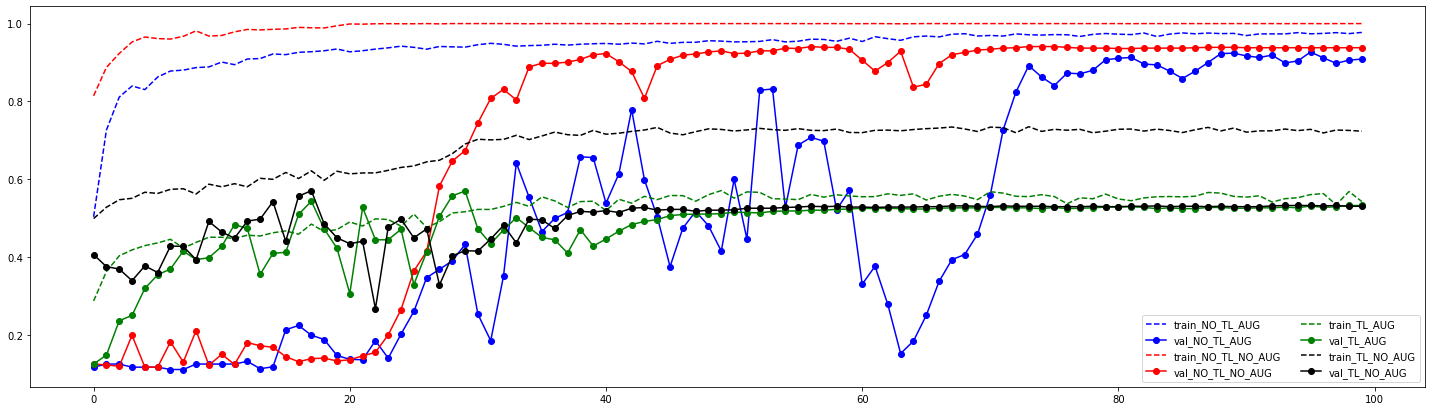

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(25, 7))
ax = accuracies.plot(
    ax=ax,
    color=[
        'blue', 'blue',
        'red', 'red',
        'green', 'green',
        'black', 'blacK'
    ],
    style=[
        '--', '-o',
        '--', '-o',
        '--', '-o',
        '--', '-o'
    ]
)
ax.legend(
    [
        'train_NO_TL_AUG',
        'val_NO_TL_AUG',
        'train_NO_TL_NO_AUG',
        'val_NO_TL_NO_AUG',
        'train_TL_AUG',
        'val_TL_AUG',
        'train_TL_NO_AUG',
        'val_TL_NO_AUG',
    ],
    ncol=2
)
ax.set